In [288]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from numba import jit, njit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import N_A
import math

In [289]:
@njit
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

@njit
def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

@njit
def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

@njit
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):

    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =  k3*(A0)*(rf) - 2*k2off*z[2] - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def S_two_cells1(t, z, p):

    k1 = p[0]
    k2 = p[1]
    k3 = p[2]
    k4 = p[3]
    k5 = p[4]
    k6 = p[5]
    k7 = p[6]
    k1off = p[7]
    k2off = p[8]
    rtot_synapse = p[9]
    rtot_fc_synapse = p[10]
    Atot = p[11] 
    
    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =  k3*(A0)*(rf) - 2*k2off*z[2] - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = np.asarray([dA10, dA20, dA01, dA11, dA21])

    return dz

In [290]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 1
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [291]:
CD4_variants = ['Ibalizumab', 'VKY91A', 'VKR95A', 'VHY99A']
CD4_on_rates = [2.1e5, 1.7e5, 3e5, 2.8e5]
CD4_off_rates = [1.8e-4, 4.2e-3, 1.6e-2, 2.e-2]
#CD4_on_rates = [1e5, 1e5, 1e5, 1e5]
#CD4_off_rates = [1e-4, 1e-3, 1e-2, 5e-2]

D_t = 5e-14
rtot = 1e5
qon = 6.5e3
qoff = 4.7e-3
ftot= 2.2e5
D_f = 7.4e-14

rtot_synapse = rtot*tumour_cell_IS_proportion
ftot_synapse = ftot*NK_cell_IS_proportion

A0s = np.geomspace(1e-12, 1e-4, 75)

t_end = 60*60*10000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

In [292]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = (2*(D_t +D_f)/(synapse_area))/1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-5, atol=1e-5, t_eval=t, args=[k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return crosslinks

In [293]:
crosslinks = np.zeros((len(CD4_on_rates), len(A0s)))

crosslinks_1 = np.zeros((len(CD4_on_rates), len(A0s)))

CD4_variants = ['Ibalizumab', 'VKY91A', 'VKR95A', 'VHY99A']
CD4_on_rates = [2.1e5, 1.7e5, 3e5, 2.8e5]
CD4_off_rates = [1.8e-4, 4.2e-3, 1.6e-2, 2.e-2]

D_t = 5e-14
rtot = 1e5
qon = 6.5e3
qoff = 4.7e-3
ftot= 2.2e3
D_f = 7.4e-14
for i, kon in enumerate(CD4_on_rates):
    print(i)
    koff = CD4_off_rates[i]

    for j, Ainit in enumerate(A0s):
        
       vals = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 1)
       crosslinks[i, j] = vals
       #crosslinks_1[i, j] = vals[2]


0
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached 

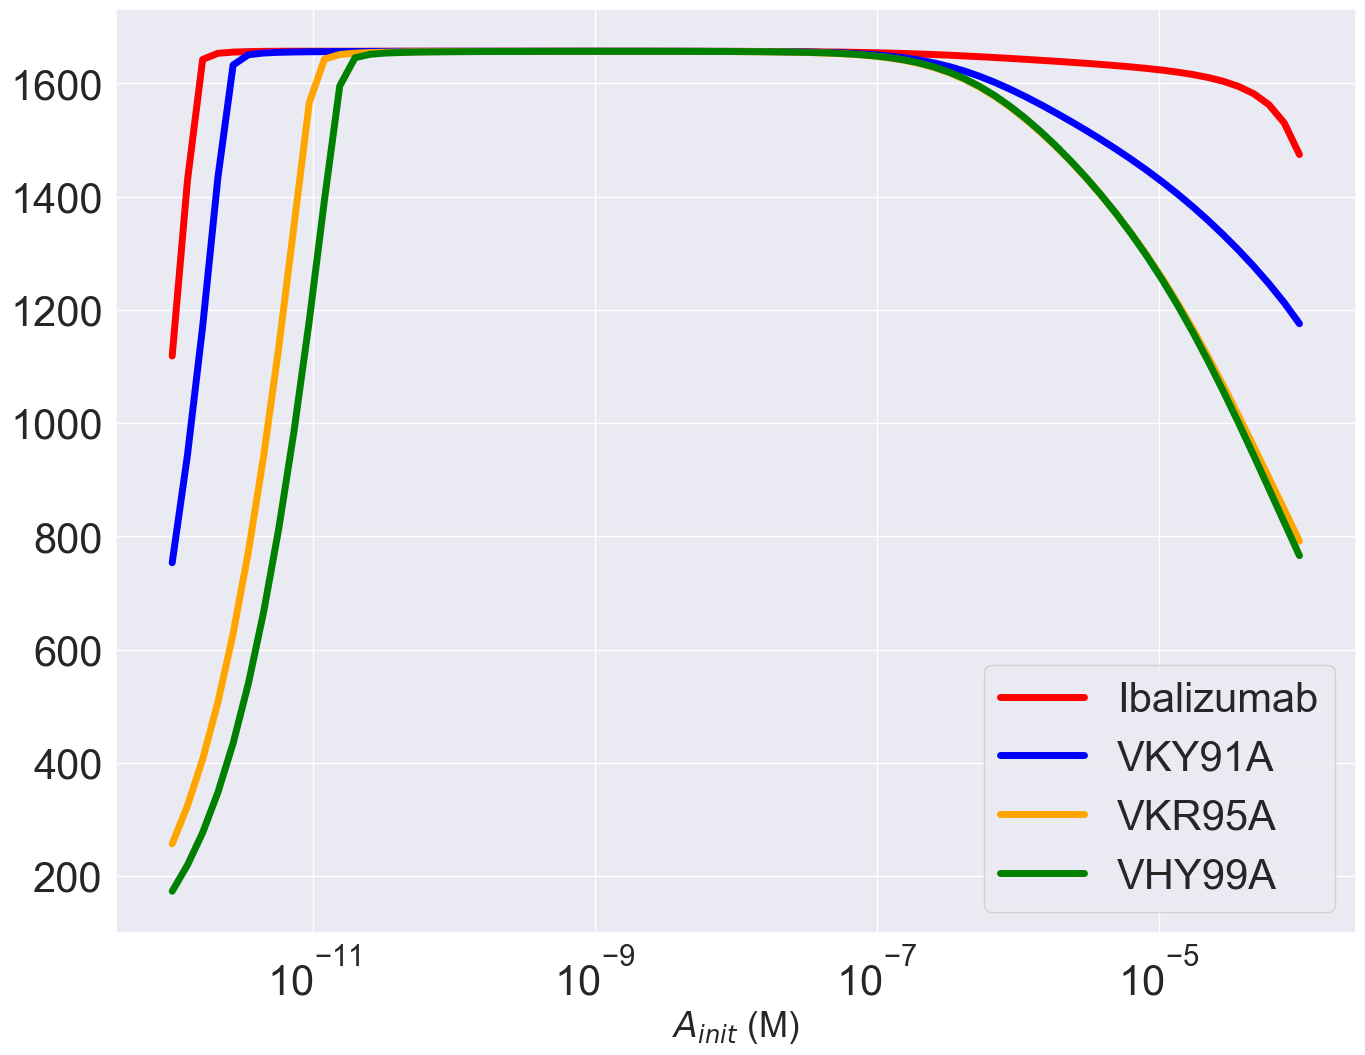

In [294]:
sns.set_context('talk')
sns.set_theme()
colors=['red', 'blue', 'orange', 'green']
fig, ax = plt.subplots(figsize=(16, 12))
for i in range(len(CD4_on_rates)):
    ax.semilogx(A0s, crosslinks[i, :], label=CD4_variants[i], lw=5, c=colors[i])
    #ax.semilogx(A0s, crosslinks_1[i, :], label=CD4_variants[i], lw=5, linestyle = '--')

ax.tick_params(labelsize=30)
ax.legend(loc='best', fontsize=30)
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=25)
plt.show()